In [138]:
import sklearn
import numpy as np
from tensorflow import keras
from explainer.metrics import draw_network, metrics, markov_blanket
from pgmpy.utils import get_example_model
import wandb
import copy
from ucimlrepo import fetch_ucirepo
import plotly.graph_objects as go
from lime.lime_tabular import LimeTabularExplainer
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import re

In [6]:
wandb.login()

wandb: Currently logged in as: mkwambetumelo (wits-nlp) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

#### Data

  0%|          | 0/32 [00:00<?, ?it/s]

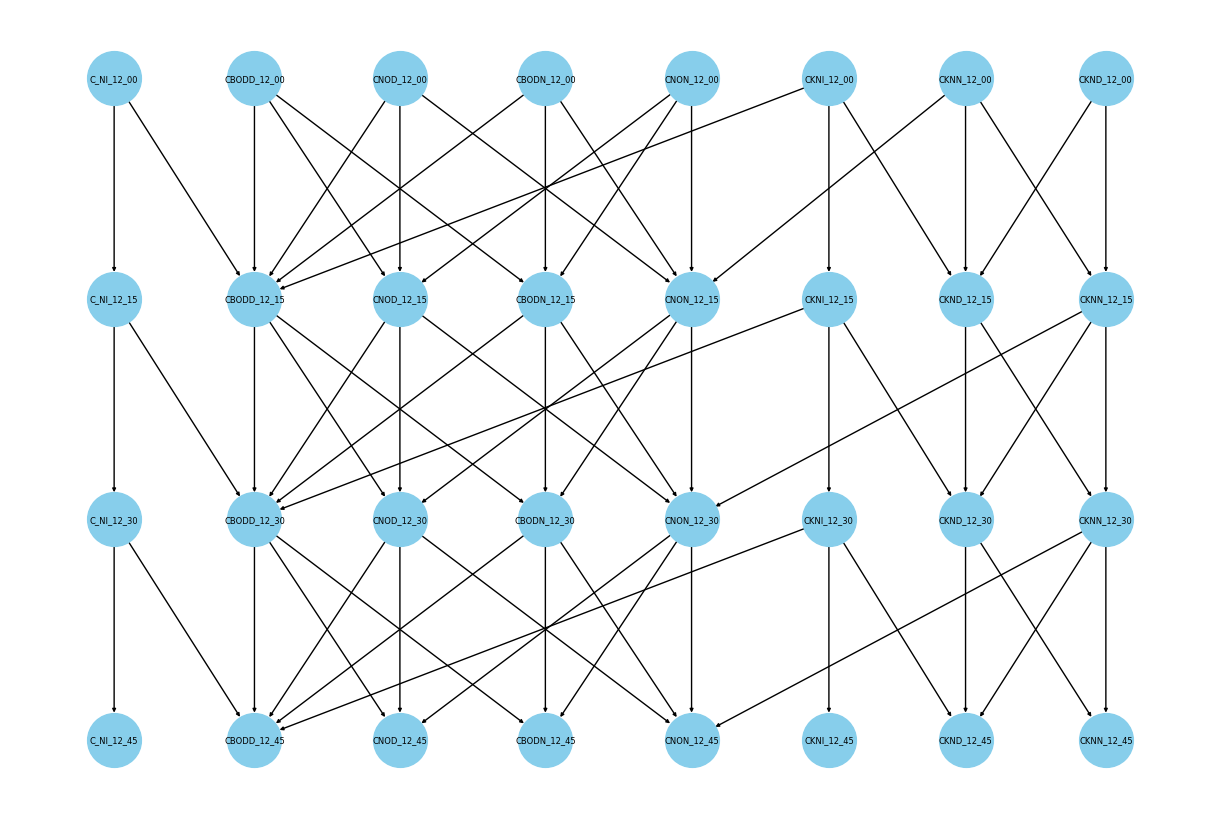

In [366]:
ground_bn = get_example_model("water")

dataset = ground_bn.simulate(n_samples = 1000)

draw_network(ground_bn)

In [367]:
dataset.columns

Index(['CBODN_12_00', 'CBODD_12_00', 'CBODD_12_45', 'CNOD_12_00', 'CKNI_12_00',
       'CKNI_12_45', 'C_NI_12_00', 'CKND_12_15', 'CKNN_12_00', 'CNOD_12_15',
       'CNOD_12_45', 'CKNI_12_30', 'CBODN_12_30', 'CKND_12_45', 'CNOD_12_30',
       'CKNN_12_45', 'CBODN_12_15', 'CKND_12_00', 'CBODD_12_15', 'CKNN_12_15',
       'CNON_12_45', 'CBODD_12_30', 'CNON_12_15', 'C_NI_12_45', 'CBODN_12_45',
       'CNON_12_00', 'CKNN_12_30', 'CNON_12_30', 'C_NI_12_30', 'C_NI_12_15',
       'CKNI_12_15', 'CKND_12_30'],
      dtype='object')

In [384]:
target_name = 'CNON_12_45'
feature_names = list(dataset.drop(target_name, axis = 1).columns)

X = dataset.drop(target_name, axis = 1).to_numpy()
y = dataset[target_name].to_numpy()

In [385]:
feature_encoder = sklearn.preprocessing.OrdinalEncoder()
feature_encoder.fit(X)

target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(y.squeeze())

X = feature_encoder.transform(X)
y = target_encoder.transform(y)

In [386]:
X_train, X_test, y_train, y_test = train_test_split(X, y.squeeze(), test_size = 0.2, random_state = 42)

#### Model

In [387]:
model = RandomForestClassifier(random_state = 0)
model.fit(X_train, y_train.squeeze())

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [388]:
accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9800


#### Explanations

In [389]:
import itertools
import numpy as np
import pandas as pd
from pgmpy.base import PDAG
from pgmpy.estimators import PC, HillClimbSearch, ExpertKnowledge
from mlxtend.frequent_patterns import fpgrowth, association_rules
from scipy.stats import chi2_contingency
import pandas as pd

In [390]:
class Explainer:
    
    def __init__(self, model, training_data, feature_names, target_name, n_samples = 100, rep_prob = 0.5):

        self.model = model
        self.training_data = training_data
        self.feature_names = feature_names
        self.target_name = target_name
        self.n_samples = n_samples
        self.rep_prob = rep_prob
        
        self.local_data = None
        self.global_data = None
        self.blanket = None
        self.dag = None

    def reset(self):

        self.local_data = None
        self.blanket = None
        self.dag = None
        
    def data_generation(self, instance):
        
        instance_prediction = self.model.predict(instance.reshape(1, -1)).squeeze(0)
        
        random_indices = np.random.randint(len(self.training_data), size = self.n_samples)
        random_datapoints = self.training_data[random_indices]
        
        replacement_mask = np.random.rand(self.n_samples, random_datapoints.shape[1]) < self.rep_prob

        samples = np.where(replacement_mask, instance, random_datapoints)
                
        sample_predictions = self.model.predict(samples)
                
        sample_prediction_masks = sample_predictions != instance_prediction
        
        sample_masks = samples != instance
        
        masked_samples = sample_masks.astype(int)
        masked_sample_predictions = sample_prediction_masks.astype(int)
        
        self.local_data = pd.DataFrame(masked_samples, columns = self.feature_names)
        self.local_data[self.target_name] = masked_sample_predictions
        
        self.global_data = pd.concat([self.global_data, self.local_data], ignore_index = True)

    def get_structure(self, scope = 'local'):

        data = None

        if scope == 'local':
            
            data = self.local_data

        elif scope == 'global':
            
            data = self.global_data

        else:

            raise ValueError("scope can only be local or global")
        
        est = PC(data)
        
        dag = est.estimate(ci_test = "chi_square", return_type = "dag")

        self.dag = markov_blanket(dag, self.target_name)

        self.blanket = dag.get_markov_blanket(self.target_name)
        
    def log_data(self, instance):

        self.reset()
        self.data_generation(instance)

#### Variable Associations (RQ1)
##### Comparison of global associations

In [398]:
explainer = Explainer(model, X_train, feature_names, target_name, 5000, 0.1)

instance = X_train[np.random.randint(X_train.shape[0])]
    
explainer.log_data(instance)

explainer.get_structure('local')

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'CBODN_12_00': 'N', 'CBODD_12_00': 'N', 'CBODD_12_45': 'N', 'CNOD_12_00': 'N', 'CKNI_12_00': 'N', 'CKNI_12_45': 'N', 'C_NI_12_00': 'N', 'CKND_12_15': 'N', 'CKNN_12_00': 'N', 'CNOD_12_15': 'N', 'CNOD_12_45': 'N', 'CKNI_12_30': 'N', 'CBODN_12_30': 'N', 'CKND_12_45': 'N', 'CNOD_12_30': 'N', 'CKNN_12_45': 'N', 'CBODN_12_15': 'N', 'CKND_12_00': 'N', 'CBODD_12_15': 'N', 'CKNN_12_15': 'N', 'CBODD_12_30': 'N', 'CNON_12_15': 'N', 'C_NI_12_45': 'N', 'CBODN_12_45': 'N', 'CNON_12_00': 'N', 'CKNN_12_30': 'N', 'CNON_12_30': 'N', 'C_NI_12_30': 'N', 'C_NI_12_15': 'N', 'CKNI_12_15': 'N', 'CKND_12_30': 'N', 'CNON_12_45': 'N'}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting


Ground Markov Blanket: ['CNOD_12_30', 'CKNN_12_30', 'CBODN_12_30', 'CNON_12_30'] 

Explainer Markov Blanket: ['CNON_12_30', 'CNON_12_15'] 

Markov Blanket Accuracy: 1 / 5
Ground Markov Blanket: 



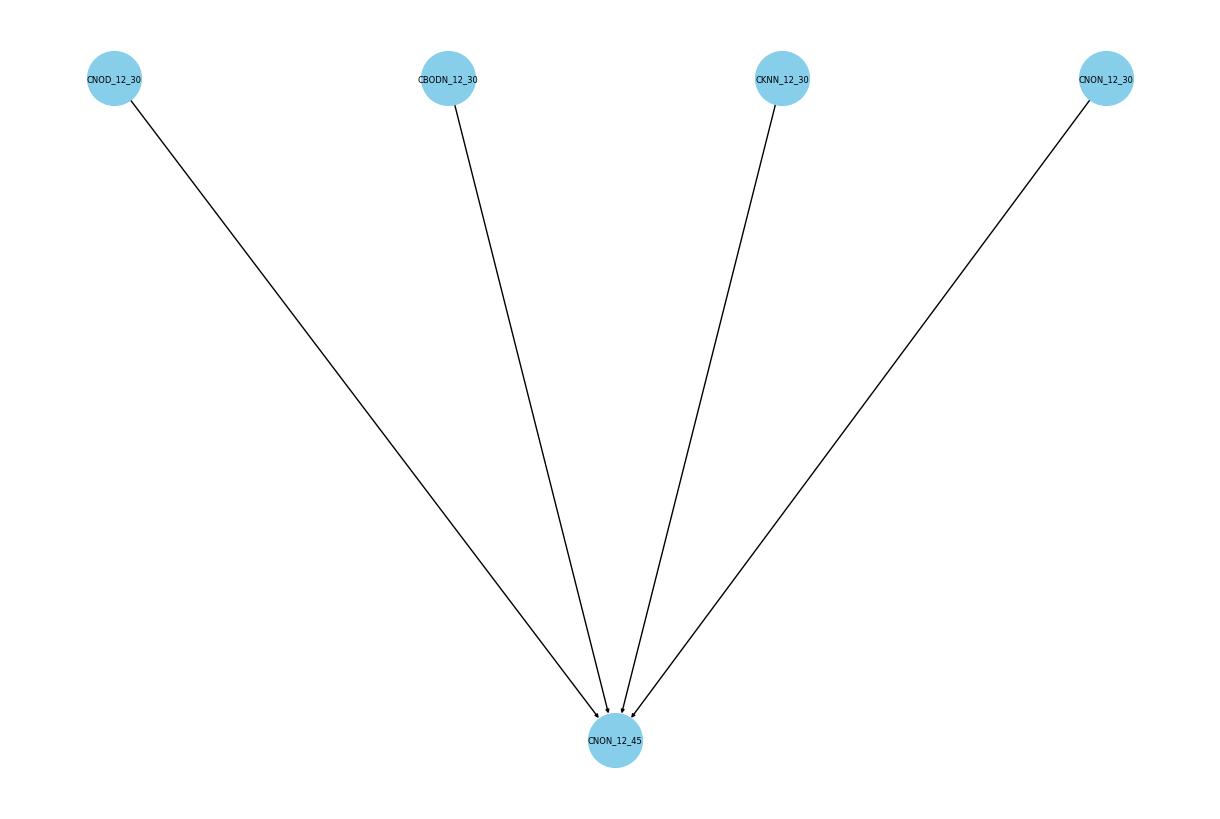

Explainer Markov Blanket: 



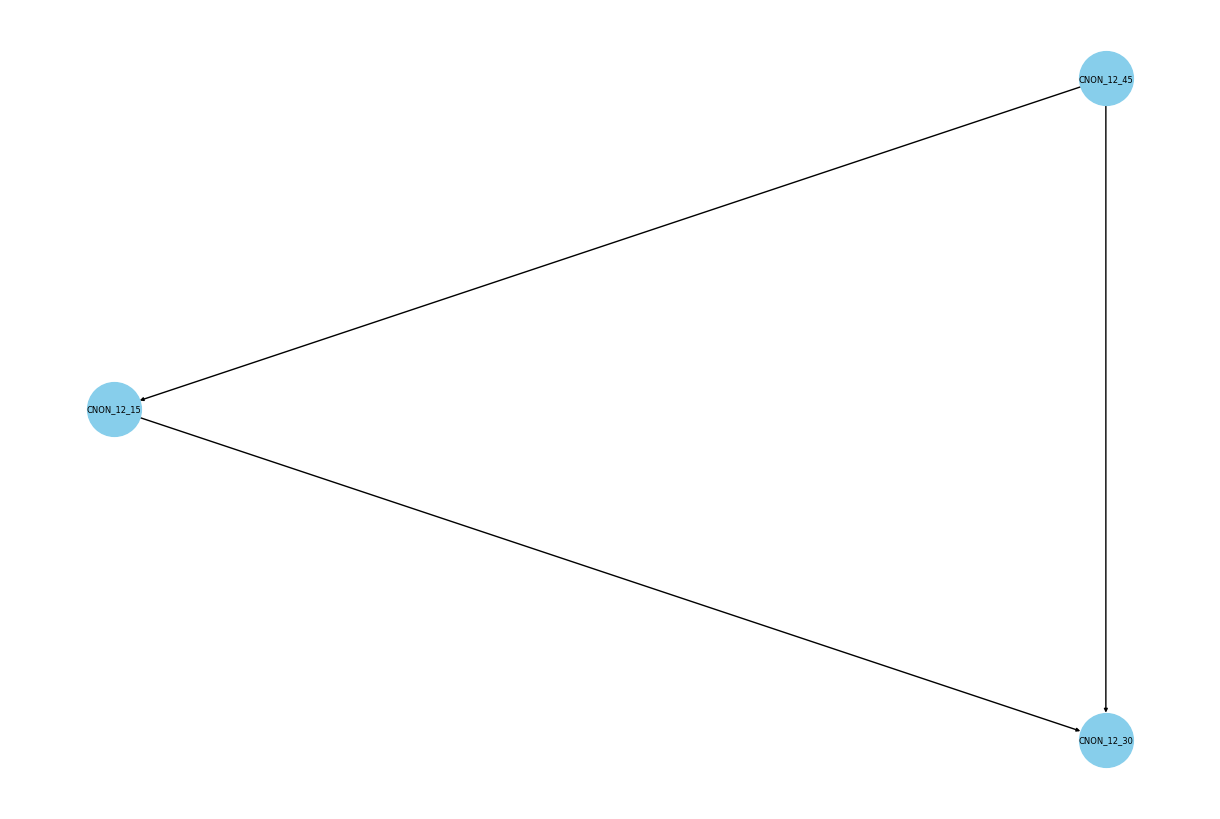

In [399]:
metrics(ground_bn, explainer.dag, target_name)

In [ ]:
ground_distributions, ground_og_distro = local_fidelity(
    instance = instance,
    training_data = X_train,
    feature_set = ground_bn.get_markov_blanket(target_name),
    model = model,
    n_trials = 100
)

fidelity_plot(
    distributions = ground_distributions,
    og_distro = ground_og_distro,
    title = 'Ground Markov Blanket'
)

wandb: ERROR Control-C detected -- Run data was not synced


In [ ]:
explainer = Explainer(model, X_train, feature_names, target_name, 5000, 0.1)

explainer.log_data(instance)
explainer.get_structure('local')

distributions, og_distro = local_fidelity(
    instance = instance,
    training_data = X_train,
    feature_set = explainer.blanket,
    model = model,
    n_trials = 100
)

fidelity_plot(
    distributions = distributions,
    og_distro = og_distro,
    title = 'Explainer Markov Blanket'
)